# Generate ROC Curves for different subgroups of the Balance Faces in the Wild (BFW) dataset.

Uses the data in `data/bfw-datatable.pkl` to evaluate DET curves of different attributes.

In [7]:
%load_ext autoreload
%autoreload 2
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from sklearn.metrics import roc_auc_score, roc_curve
import seaborn as sns

sns.set(font_scale=1.1)
# Load out custom tool for loading and processing the data
from facebias.iotools import load_bfw_datatable, makedir

%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setings for notebook run
set values per preferences for current session

In [ ]:
fontsize=12

# plotting
sns.set_style("whitegrid")
sns.set_context("paper", rc={"font.size": fontsize, "axes.titlesize": fontsize, "axes.labelsize": fontsize})

# parameters and filepaths
ticks_to_use_x=(1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0)

# datatable (See Load Data)
dir_data = '../../data/bfw/'
dir_features = f'{dir_data}features/sphereface/'
f_datatable = f'{dir_data}meta/bfw-v0.1.5-datatable.pkl'
use_feature = 'sphereface'

dir_results = f"../../results/roc/{use_feature}/"
makedir(dir_results)


save_plots = True # save plots to disc, in folder 'dir_out'
save_intermediate = True # save data to replot det curves without waiting for calculations
overwrite_existing = True # only save if files do not exist

opts = [{'color': 'g', 'alpha': 0.7, 'norm_hist': True}, {'color': 'r', 'alpha': 0.7, 'norm_hist': True}] # currently not used

## Load the data

Read in the data as a pandas.DataFrame and display the first few rows.

More information and process to build datatable is exemplified in [0_prepare_datatable.ipynb](0_prepare_datatable.ipynb).

Scores for pairs are assumed to be calculated and added as column of datatable. The process for adding this column is demonstrated in [1_compare_features.ipynb](1_compare_features.ipynb)

**Note** that the demo uses scores from setnet50, as it creates a column *score* with the respective values. Just set *score* column to any set of scores that are intended for analysis.

In [25]:
data = load_bfw_datatable(f_datatable)
data['score'] = data[use_feature]
data.head()
data=data.loc[data.a1==data.a2]

In [4]:
classes_abbreviated = np.unique(list(np.unique(data.a1)) + list(np.unique(data.a2)))
classes_abbreviated.sort()

print(f"there are {len(classes_abbreviated)} types: {classes_abbreviated}")

there are 8 types: ['AF' 'AM' 'BF' 'BM' 'IF' 'IM' 'WF' 'WM']


In [27]:
subgroups = data.groupby('a1')
li_subgroups = subgroups.groups

In [30]:
def set_roc_labels(ax, f_out, save_plots, overwrite):
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'))
    plt.minorticks_off()
    ax.set_ylabel('True Accept Rate (%)',fontsize=fontsize+2)
    ax.set_xlabel('False Accept Rate', fontsize=fontsize+2)
    ax.legend(fontsize=fontsize)
    ax.set_xlim([1e-4, 1])
    ax.set_ylim([0, 1])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12) 
    plt.grid(False)
    if save_plots and overwrite_existing:
        plt.savefig(f"{f_out}.pdf")
        plt.savefig(f"{f_out}.png")

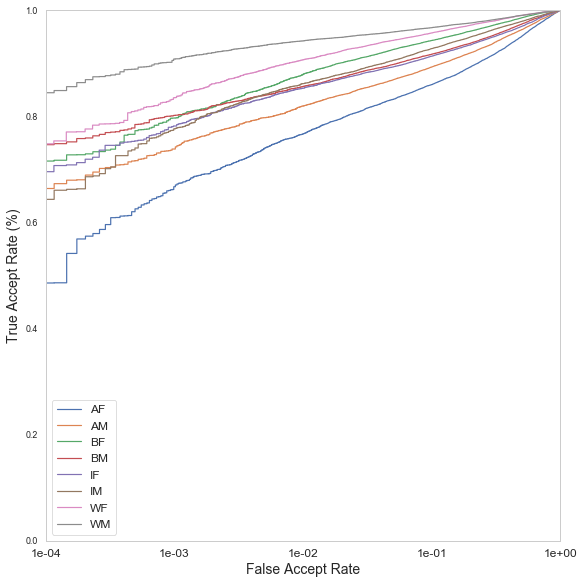

In [31]:
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(1, 3)

ax1 = fig.add_subplot(gs[0, :])
for i, subgroup in enumerate(li_subgroups):
    # for each subgroup
    fout = f"{dir_results}/roc_data_{subgroup}.pkl"
    if pathlib.Path(fout).is_file() and not overwrite_existing:
        roc_data = pd.read_pickle(fout)
        
        fpr, tpr, thresholds = roc_data['fpr'], roc_data['fpr'], roc_data['thresholds']
    else:
        df_subgroup = subgroups.get_group(subgroup)
        labels, scores = df_subgroup['label'].values.astype(int), df_subgroup['score'].values
        fpr, tpr, thresholds = roc_curve(labels, scores, pos_label=1)
        if save_intermediate:
            pd.to_pickle({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds}, fout)
        ax1.semilogx(fpr, tpr, label=subgroup)  
#         sns.lineplot(fpr, tpr, label=subgroup, ax=ax1)
set_roc_labels(ax1, f"{dir_results}curves_subgroups", save_plots, overwrite_existing)


In [32]:
subgroups = data.groupby('g1')
li_subgroups = subgroups.groups
classes_abbreviated=list(li_subgroups.keys())
print(f"there are {len(classes_abbreviated)} types: {classes_abbreviated}")

there are 2 types: ['F', 'M']


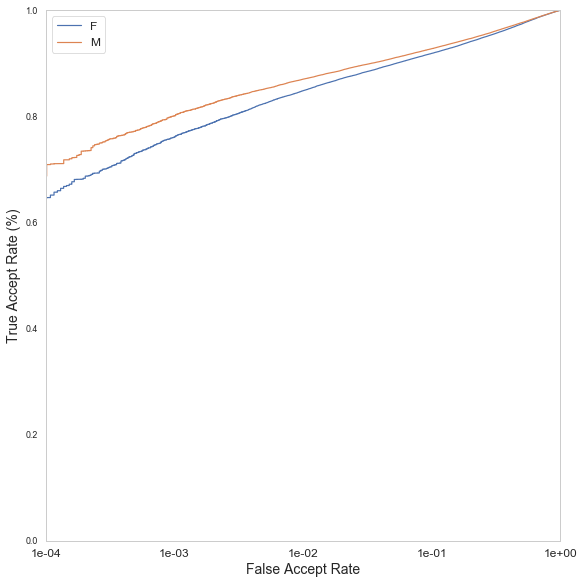

In [33]:
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(1, 3)

ax1 = fig.add_subplot(gs[0, :])


for i, subgroup in enumerate(li_subgroups):
    # for each subgroup
    fout = f"{dir_results}/roc_data_{subgroup}.pkl"
    if pathlib.Path(fout).is_file() and not overwrite_existing:
        roc_data = pd.read_pickle(fout)
        
        fpr, tpr, thresholds = roc_data['fpr'], roc_data['fpr'], roc_data['thresholds']
    else:
        df_subgroup = subgroups.get_group(subgroup)
        labels, scores = df_subgroup['label'].values.astype(int), df_subgroup['score'].values
        fpr, tpr, thresholds = roc_curve(labels, scores, pos_label=1)
        if save_intermediate:
            pd.to_pickle({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds}, fout)
        ax1.semilogx(fpr, tpr, label=subgroup)  
#         sns.lineplot(fpr, tpr, label=subgroup, ax=ax1)
#         plt.semilogx(fpr, tpr)
set_roc_labels(ax1, f"{dir_results}curves_gender", save_plots, overwrite_existing)


In [34]:
subgroups = data.groupby('e1')
li_subgroups = subgroups.groups
classes_abbreviated=list(li_subgroups.keys())
print(f"there are {len(classes_abbreviated)} types: {classes_abbreviated}")

there are 4 types: ['A', 'B', 'I', 'W']


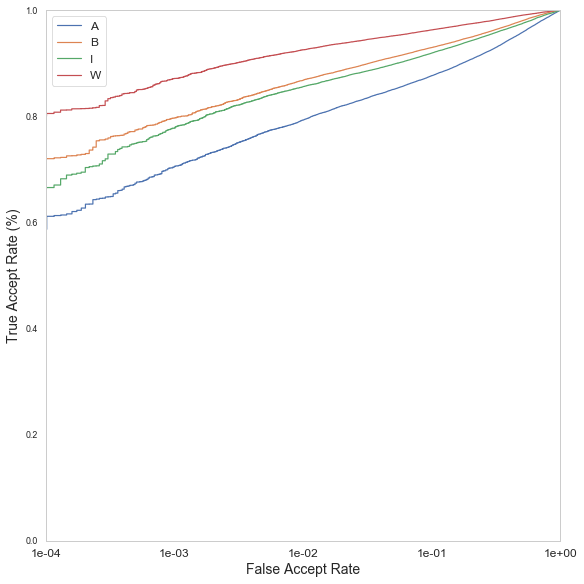

In [40]:
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(1, 3)

ax1 = fig.add_subplot(gs[0, :])
for i, subgroup in enumerate(li_subgroups):
    # for each subgroup
    fout = f"{dir_results}/det_data_{subgroup}.pkl"
    if pathlib.Path(fout).is_file() and not overwrite_existing:
        det_data = pd.read_pickle(fout)
        fpr, tpr, thresholds = det_data['fpr'], det_data['tpr'], det_data['thresholds']
    else:
        df_subgroup = subgroups.get_group(subgroup)
        labels, scores = df_subgroup['label'].values.astype(int), df_subgroup['score'].values
        fpr, tpr, thresholds = roc_curve(labels, scores, pos_label=1)
        if save_intermediate:
            pd.to_pickle({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds}, fout)
        ax1.semilogx(fpr, tpr, label=subgroup)  
#     ax1 = draw_det_curve(fpr, fnr, ax=ax1, label=subgroup, fontsize=fontsize, title='DET Curve (Per Ethnicity)')

set_roc_labels(ax1, f"{dir_results}curve_ethnicity", save_plots, overwrite_existing)